## from https://web.stanford.edu/~boyd/papers/admm/

# Code

In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/logreg-l1/logreg.html")


code =

    'function [z, history] = logreg(A, b, mu, rho, alpha)
     % logreg   Solve L1 regularized logistic regression via ADMM
     %
     % [z, history] = logreg(A, b, mu, rho, alpha)
     %
     % solves the following problem via ADMM:
     %
     %   minimize   sum( log(1 + exp(-b_i*(a_i'w + v)) ) + m*mu*norm(w,1)
     %
     % where A is a feature matrix and b is a response vector. The scalar m is
     % the number of examples in the matrix A.
     %
     % This solves the L1 regularized logistic regression problem. It uses
     % a custom Newton solver for the x-step.
     %
     % The solution is returned in the vector x = (v,w).
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % norms at each iteration.
     % 
     % rho is the augmented Lagrangian parameter. 
     %
     % alpha is the over-relaxation parameter (typical values for alpha are 
     %

In [2]:
%%file logreg.m

function [z, history] = logreg(A, b, mu, rho, alpha)
% logreg   Solve L1 regularized logistic regression via ADMM
%
% [z, history] = logreg(A, b, mu, rho, alpha)
%
% solves the following problem via ADMM:
%
%   minimize   sum( log(1 + exp(-b_i*(a_i'w + v)) ) + m*mu*norm(w,1)
%
% where A is a feature matrix and b is a response vector. The scalar m is
% the number of examples in the matrix A.
%
% This solves the L1 regularized logistic regression problem. It uses
% a custom Newton solver for the x-step.
%
% The solution is returned in the vector x = (v,w).
%
% history is a structure that contains the objective value, the primal and
% dual residual norms, and the tolerances for the primal and dual residual
% norms at each iteration.
%
% rho is the augmented Lagrangian parameter.
%
% alpha is the over-relaxation parameter (typical values for alpha are
% between 1.0 and 1.8).
%
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%


t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

%% Data preprocessing

[m, n] = size(A);

%% ADMM solver

x = zeros(n+1,1);
z = zeros(n+1,1);
u = zeros(n+1,1);


if ~QUIET
    fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
      'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end

for k = 1:MAX_ITER

    % x-update
    x = update_x(A, b, u, z, rho);

    % z-update with relaxation
    zold = z;
    x_hat = alpha*x + (1-alpha)*zold;
    z = x_hat + u;
    z(2:end) = shrinkage(z(2:end), (m*mu)/rho);

    u = u + (x_hat - z);

    % diagnostics, reporting, termination checks
    history.objval(k)  = objective(A, b, mu, x, z);

    history.r_norm(k)  = norm(x - z);
    history.s_norm(k)  = norm(rho*(z - zold));


    history.eps_pri(k) = sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(z));
    history.eps_dual(k)= sqrt(n)*ABSTOL + RELTOL*norm(rho*u);

    if ~QUIET
        fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, ...
            history.r_norm(k), history.eps_pri(k), ...
            history.s_norm(k), history.eps_dual(k), history.objval(k));
    end


    if history.r_norm(k) < history.eps_pri(k) && ...
       history.s_norm(k) < history.eps_dual(k)
        break;
    end
end

if ~QUIET
    toc(t_start);
end
end

function obj = objective(A, b, mu, x, z)
    m = size(A,1);
    obj = sum(log(1 + exp(-A*x(2:end) - b*x(1)))) + m*mu*norm(z,1);
end

function x = update_x(A, b, u, z, rho, x0)
    % solve the x update
    %   minimize [ -logistic(x_i) + (rho/2)||x_i - z^k + u^k||^2 ]
    % via Newton's method; for a single subsystem only.
    alpha = 0.1;
    BETA  = 0.5;
    TOLERANCE = 1e-5;
    MAX_ITER = 50;
    [m n] = size(A);
    I = eye(n+1);
    if exist('x0', 'var')
        x = x0;
    else
        x = zeros(n+1,1);
    end
    C = [-b -A];
    f = @(w) (sum(log(1 + exp(C*w))) + (rho/2)*norm(w - z + u).^2);
    for iter = 1:MAX_ITER
        fx = f(x);
        g = C'*(exp(C*x)./(1 + exp(C*x))) + rho*(x - z + u);
        H = C' * diag(exp(C*x)./(1 + exp(C*x)).^2) * C + rho*I;
        dx = -H\g;   % Newton step
        dfx = g'*dx; % Newton decrement
        if abs(dfx) < TOLERANCE
            break;
        end
        % backtracking
        t = 1;
        while f(x + t*dx) > fx + alpha*t*dfx
            t = BETA*t;
        end
        x = x + t*dx;
    end
end
function z = shrinkage(a, kappa)
    z = max(0, a-kappa) - max(0, -a-kappa);
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/logreg.m'.


# Example

In [3]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/logreg-l1/logreg_example.html")


eg_code =

    '% L1 regularized logistic regression (not distributed)
     
     %% Generate problem data
     
     rand('seed', 0);
     randn('seed', 0);
     
     n = 50; 
     m = 200;
     
     w = sprandn(n, 1, 0.1);  % N(0,1), 10% sparse
     v = randn(1);            % random intercept
     
     X = sprandn(m, n, 10/n);
     btrue = sign(X*w + v);
     
     % noise is function of problem size use 0.1 for large problem
     b = sign(X*w + v + sqrt(0.1)*randn(m,1)); % labels with noise
     
     A = spdiags(b, 0, m, m) * X;
     
     ratio = sum(b == 1)/(m);
     mu = 0.1 * 1/m * norm((1-ratio)*sum(A(b==1,:),1) + ratio*sum(A(b==-1,:),1), 'inf');
     
     x_true = [v; w];
     
     %% Solve problem
     
     [x history] = logreg(A, b, mu, 1.0, 1.0);
     
     %% Reporting
     
     K = length(history.objval);                                                                                                        
     
     h = figure;
     plot(1:K, history.objval, 'k

### Generate problem data

In [4]:
rand('seed', 0);
randn('seed', 0);

n = 50;
m = 200;

w = sprandn(n, 1, 0.1);  % N(0,1), 10% sparse
v = randn(1);            % random intercept

X = sprandn(m, n, 10/n);
btrue = sign(X*w + v);

% noise is function of problem size use 0.1 for large problem
b = sign(X*w + v + sqrt(0.1)*randn(m,1)); % labels with noise

A = spdiags(b, 0, m, m) * X;

ratio = sum(b == 1)/(m);
mu = 0.1 * 1/m * norm((1-ratio)*sum(A(b==1,:),1) + ratio*sum(A(b==-1,:),1), 'inf');

x_true = [v; w];

### Solve problem

In [5]:
[x history] = logreg(A, b, mu, 1.0, 1.0);

iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	    3.3583	    0.0489	    2.9421	    0.0343	     31.57
  2	    1.5574	    0.0439	    1.8655	    0.0469	     40.27
  3	    0.9098	    0.0469	    0.8803	    0.0530	     43.50
  4	    0.6102	    0.0489	    0.4102	    0.0573	     44.71
  5	    0.4396	    0.0499	    0.1878	    0.0602	     45.56
  6	    0.3283	    0.0503	    0.0802	    0.0624	     46.12
  7	    0.2521	    0.0504	    0.0318	    0.0641	     46.51
  8	    0.1979	    0.0505	    0.0133	    0.0654	     46.79
  9	    0.1580	    0.0505	    0.0083	    0.0663	     46.99
 10	    0.1201	    0.0505	    0.0220	    0.0671	     47.18
 11	    0.0916	    0.0505	    0.0358	    0.0676	     47.34
 12	    0.0719	    0.0505	    0.0133	    0.0679	     47.42
 13	    0.0575	    0.0505	    0.0060	    0.0683	     47.47
 14	    0.0463	    0.0505	    0.0037	    0.0685	     47.52
 0.127410 


### Reporting

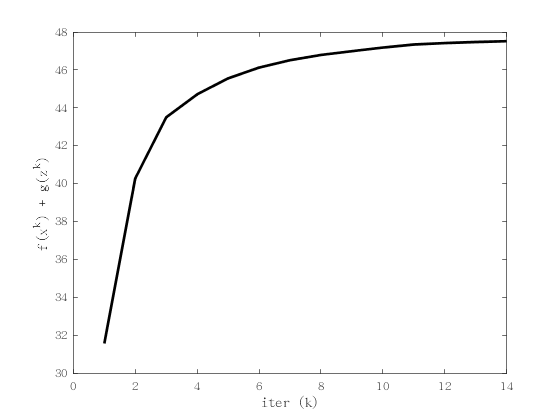

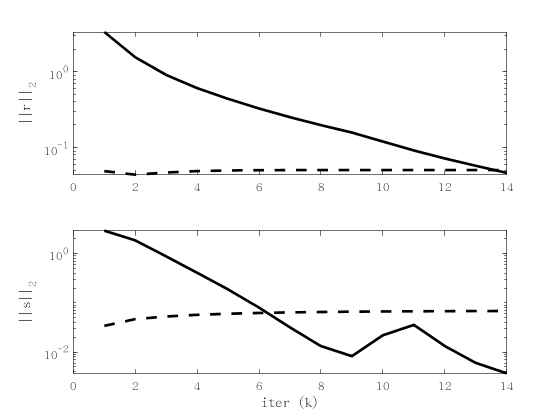

In [6]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');